## FEDWPR (5% WITHOUT HYPERPARAMETER TUNING)

In [ ]:
!pip install tensorflow federated
!pip install gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile

# Unzip the datasets
zip_path = '/content/drive/My Drive/BTP.zip'
unzip_path = '/content/datasets'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)


Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Function to load and preprocess data with augmentation
def load_data(client_path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(client_path, 'train'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        os.path.join(client_path, 'test'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator, test_generator

clients = ["/content/datasets/Non-iid datasets/non_iid_subset_1","/content/datasets/Non-iid datasets/non_iid_subset_2","/content/datasets/Non-iid datasets/non_iid_subset_3","/content/datasets/Non-iid datasets/non_iid_subset_4",]
data_paths = [os.path.join(unzip_path, client) for client in clients]

train_generators = []
test_generators = []
for path in data_paths:
    train_gen, test_gen = load_data(path)
    train_generators.append(train_gen)
    test_generators.append(test_gen)


Found 19012 images belonging to 19 classes.
Found 4748 images belonging to 19 classes.
Found 19185 images belonging to 19 classes.
Found 4791 images belonging to 19 classes.
Found 19703 images belonging to 19 classes.
Found 4921 images belonging to 19 classes.
Found 19530 images belonging to 19 classes.
Found 4878 images belonging to 19 classes.


In [ ]:
def create_model(num_classes=19):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


In [ ]:
import numpy as np

# Define number of communication rounds and hyperparameters grid
num_rounds = 5
hyperparameters_grid = {
    'RR': [0.3, 0.5, 0.7],
    'epochs': [5, 10]
}

def fed_wpr(client_models, RR):
    new_weights_list = []
    client_weights = [model.get_weights() for model in client_models]

    for client_id in range(len(client_models)):
        new_weights = []
        for layer_weights in zip(*client_weights):
            weighted_sum = np.zeros_like(layer_weights[0])
            for j in range(len(client_models)):
                weighted_sum += RR * layer_weights[j]
            personalized_weights = (1 - RR) * layer_weights[client_id] + weighted_sum
            new_weights.append(personalized_weights)
        new_weights_list.append(new_weights)

    return new_weights_list

def train_and_evaluate(client_models, train_generators, test_generators, RR, epochs, num_rounds=10):
    for round_num in range(num_rounds):
        print(f'Round {round_num+1}/{num_rounds}')

        for i in range(4):
            print(f'Training client {i+1}')
            client_models[i].fit(train_generators[i], epochs=epochs, validation_data=test_generators[i])

        new_weights_list = fed_wpr(client_models, RR)

        for i in range(4):
            client_models[i].set_weights(new_weights_list[i])

    avg_accuracy = 0
    for i in range(4):
        loss, accuracy = client_models[i].evaluate(test_generators[i])
        avg_accuracy += accuracy
        print(f'Client {i+1} - Loss: {loss}, Accuracy: {accuracy}')

    avg_accuracy /= 4
    return avg_accuracy

def grid_search(hyperparameters_grid):
    best_accuracy = 0
    best_params = {}

    for RR in hyperparameters_grid['RR']:
        for epochs in hyperparameters_grid['epochs']:
            print(f'Evaluating RR = {RR}, epochs = {epochs}')
            client_models = [create_model(num_classes=19) for _ in range(4)]

            avg_accuracy = train_and_evaluate(client_models, train_generators, test_generators, RR, epochs)

            print(f'Average accuracy for RR = {RR}, epochs = {epochs}: {avg_accuracy}')

            if avg_accuracy > best_accuracy:
                best_accuracy = avg_accuracy
                best_params = {'RR': RR, 'epochs': epochs}

    return best_params, best_accuracy

best_params, best_accuracy = grid_search(hyperparameters_grid)
print(f'Best parameters: {best_params} with average accuracy: {best_accuracy}')


Evaluating RR = 0.3, epochs = 5
9406464/9406464 [==============================] - 2s 0us/step
Round 1/10
Training client 1
Epoch 1/5
595/595 [==============================] - 322s 526ms/step - loss: 2.5215 - accuracy: 0.2138 - val_loss: 2.2394 - val_accuracy: 0.3317
Epoch 2/5
595/595 [==============================] - 266s 446ms/step - loss: 2.2101 - accuracy: 0.3029 - val_loss: 1.8453 - val_accuracy: 0.4164
Epoch 3/5
595/595 [==============================] - 263s 442ms/step - loss: 2.1064 - accuracy: 0.3348 - val_loss: 1.6908 - val_accuracy: 0.4558
Epoch 4/5
595/595 [==============================] - 262s 440ms/step - loss: 2.0058 - accuracy: 0.3617 - val_loss: 1.5987 - val_accuracy: 0.5065
Epoch 5/5
595/595 [==============================] - 265s 445ms/step - loss: 1.9645 - accuracy: 0.3811 - val_loss: 1.6173 - val_accuracy: 0.4941
Training client 2
Epoch 1/5
600/600 [==============================] - 328s 539ms/step - loss: 2.3289 - accuracy: 0.2792 - val_loss: 1.6640 - val_accur

In [ ]:
for i in range(4):
    loss, accuracy = client_models[i].evaluate(test_generators[i])
    print(f'Client {i+1} - Loss: {loss}, Accuracy: {accuracy}')

## FEDWPR (5% WITH HYPERPARAMETER TUNING)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import zipfile

# Unzip the datasets
zip_path = '/content/drive/My Drive/BTP.zip'
unzip_path = '/content/datasets'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import ParameterGrid

# Function to load and preprocess data with augmentation
def load_data(client_path):
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        os.path.join(client_path, 'train'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        os.path.join(client_path, 'test'),
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical'
    )

    return train_generator, test_generator

clients = ["/content/datasets/Non-iid datasets/non_iid_subset_1","/content/datasets/Non-iid datasets/non_iid_subset_2","/content/datasets/Non-iid datasets/non_iid_subset_3","/content/datasets/Non-iid datasets/non_iid_subset_4",]
data_paths = [os.path.join(unzip_path, client) for client in clients]

train_generators = []
test_generators = []
for path in data_paths:
    train_gen, test_gen = load_data(path)
    train_generators.append(train_gen)
    test_generators.append(test_gen)

def create_model(num_classes=19):
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define the FedWPR aggregation function
def fed_wpr(client_models, RR):
    new_weights_list = []
    client_weights = [model.get_weights() for model in client_models]

    for client_id in range(len(client_models)):
        new_weights = []
        for layer_weights in zip(*client_weights):
            weighted_sum = np.sum([w * RR for w in layer_weights], axis=0)
            personalized_weights = (1 - RR) * layer_weights[client_id] + weighted_sum
            new_weights.append(personalized_weights)
        new_weights_list.append(new_weights)

    return new_weights_list

# Train and evaluate function with learning rate scheduling and early stopping
def train_and_evaluate(client_models, train_generators, test_generators, RR, epochs, num_rounds=10):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

    for round_num in range(num_rounds):
        print(f'Round {round_num+1}/{num_rounds}')

        for i in range(4):
            print(f'Training client {i+1}')
            client_models[i].fit(train_generators[i], epochs=epochs, validation_data=test_generators[i],
                                 callbacks=[callback, lr_scheduler])

        new_weights_list = fed_wpr(client_models, RR)

        for i in range(4):
            client_models[i].set_weights(new_weights_list[i])

    avg_accuracy = 0
    for i in range(4):
        loss, accuracy = client_models[i].evaluate(test_generators[i])
        avg_accuracy += accuracy
        print(f'Client {i+1} - Loss: {loss}, Accuracy: {accuracy}')

    avg_accuracy /= 4
    return avg_accuracy

# Custom grid search function with detailed monitoring
def grid_search(hyperparameters_grid):
    best_accuracy = 0
    best_params = {}

    param_grid = list(ParameterGrid(hyperparameters_grid))

    for params in param_grid:
        RR = params['RR']
        epochs = params['epochs']

        print(f'Evaluating RR = {RR}, epochs = {epochs}')
        client_models = [create_model(num_classes=19) for _ in range(4)]

        avg_accuracy = train_and_evaluate(client_models, train_generators, test_generators, RR, epochs)

        print(f'Average accuracy for RR = {RR}, epochs = {epochs}: {avg_accuracy}')

        if avg_accuracy > best_accuracy:
            best_accuracy = avg_accuracy
            best_params = {'RR': RR, 'epochs': epochs}

    return best_params, best_accuracy

# Define hyperparameters grid
hyperparameters_grid = {
    'RR': [0.3, 0.5, 0.7],
    'epochs': [10, 20]
}

best_params, best_accuracy = grid_search(hyperparameters_grid)
print(f'Best parameters: {best_params} with average accuracy: {best_accuracy}')


Found 19012 images belonging to 19 classes.
Found 4748 images belonging to 19 classes.
Found 19185 images belonging to 19 classes.
Found 4791 images belonging to 19 classes.
Found 19703 images belonging to 19 classes.
Found 4921 images belonging to 19 classes.
Found 19530 images belonging to 19 classes.
Found 4878 images belonging to 19 classes.
Evaluating RR = 0.3, epochs = 10
9406464/9406464 [==============================] - 1s 0us/step
Round 1/10
Training client 1
Epoch 1/10
595/595 [==============================] - 347s 569ms/step - loss: 2.5186 - accuracy: 0.2171 - val_loss: 2.1193 - val_accuracy: 0.3370 - lr: 0.0010
Epoch 2/10
595/595 [==============================] - 300s 504ms/step - loss: 2.2344 - accuracy: 0.2940 - val_loss: 1.8850 - val_accuracy: 0.4021 - lr: 0.0010
Epoch 3/10
595/595 [==============================] - 274s 460ms/step - loss: 2.1054 - accuracy: 0.3365 - val_loss: 1.8559 - val_accuracy: 0.4185 - lr: 0.0010
Epoch 4/10
595/595 [==============================

## FEDWPR(NEW)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary libraries
# !pip install tensorflow
!pip install tensorflow_federated


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 68.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.9/230.9 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the dataset
zip_path = '/content/drive/MyDrive/BTP.zip'
extract_path = '/content/finger_vein_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

KeyboardInterrupt: 

In [ ]:
# Create data loaders for each client
data_dir = extract_path
batch_size = 32
img_height = 224
img_width = 224

def create_data_loader(data_path, img_height, img_width, batch_size):
    datagen = ImageDataGenerator(rescale=1./255)
    data = datagen.flow_from_directory(
        data_path,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

    return data

clients_train_data = []
clients_test_data = []
for i in range(1, 5):
    client_train_path = os.path.join(data_dir, f'/content/finger_vein_dataset/Non-iid datasets/non_iid_subset_{i}', 'train')
    client_test_path = os.path.join(data_dir, f'/content/finger_vein_dataset/Non-iid datasets/non_iid_subset_{i}', 'test')
    train_data = create_data_loader(client_train_path, img_height, img_width, batch_size)
    test_data = create_data_loader(client_test_path, img_height, img_width, batch_size)
    clients_train_data.append(train_data)
    clients_test_data.append(test_data)

Found 19012 images belonging to 19 classes.
Found 4748 images belonging to 19 classes.
Found 19185 images belonging to 19 classes.
Found 4791 images belonging to 19 classes.
Found 19703 images belonging to 19 classes.
Found 4921 images belonging to 19 classes.
Found 19530 images belonging to 19 classes.
Found 4878 images belonging to 19 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_model(num_classes):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    for layer in base_model.layers:
        layer.trainable = False
    return model


In [ ]:
import numpy as np
from tensorflow.keras.optimizers import Adam

# Client training function
def client_train(model, train_data, epochs=1):
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_data, epochs=epochs, verbose=1)
    return model.get_weights()

# FedWPR aggregation function
def fedwpr_aggregation(local_weights, RR):
    N = len(local_weights)
    new_weights = []

    for layer_weights in zip(*local_weights):
        new_layer_weights = np.zeros_like(layer_weights[0])
        for i in range(N):
            new_layer_weights += RR * np.array(layer_weights[i]) / N
        for i in range(N):
            new_layer_weights += (1 - RR) * np.array(layer_weights[i]) / N
        new_weights.append(new_layer_weights)

    return new_weights

def fedwpr_aggregation(local_weights, RR):
    N = len(local_weights)
    aggregated_weights = []

    for layer_weights in zip(*local_weights):
        rr_component = np.zeros_like(layer_weights[0])
        one_minus_rr_component = np.zeros_like(layer_weights[0])

        # Calculate RR component
        for weights in layer_weights:
            rr_component += RR * np.array(weights) / N

        # Calculate (1 - RR) component
        for weights in layer_weights:
            one_minus_rr_component += (1 - RR) * np.array(weights) / N

        # Combine both components
        new_layer_weights = rr_component + one_minus_rr_component
        aggregated_weights.append(new_layer_weights)

    return aggregated_weights

# Simulate federated learning with FedFV and FedWPR
global_model = create_model(num_classes=19)  # Assuming 20 classes for the global model
num_rounds = 10
RR = 0.5  # Set the RR value as needed

for round_num in range(num_rounds):
    local_weights = []
    for client_num, train_data in enumerate(clients_train_data):
        client_model = create_model(num_classes=train_data.num_classes)
        client_model.set_weights(global_model.get_weights())
        client_weights = client_train(client_model, train_data, epochs=1)
        local_weights.append(client_weights)

    # Apply FedWPR aggregation
    new_global_weights = fedwpr_aggregation(local_weights, RR)
    global_model.set_weights(new_global_weights)

    # Distribute the aggregated model back to clients
    for client_num, train_data in enumerate(clients_train_data):
        client_model.set_weights(new_global_weights)

    print(f'Round {round_num + 1} completed')

# Save the global model
global_model.save('/content/drive/MyDrive/federated_global_model_fedwpr.h5')


533/611 [=========================>....] - ETA: 1:21 - loss: 0.7660 - accuracy: 0.7630

In [ ]:
def evaluate_model(model, test_data):
    loss, accuracy = model.evaluate(test_data, verbose=0)
    return loss, accuracy

# Evaluate the global model on each client's test data
for client_num, test_data in enumerate(clients_test_data):
    loss, accuracy = evaluate_model(global_model, test_data)
    print(f'Client {client_num + 1} - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

# FEDWPR WITH EER , TAR@FARR=0.1

TensorFlow version: 2.17.0
OpenCV version: 4.10.0
Federated Round 1/5
Training Client 1
Compiling model for client 1
Epoch 1/5


2024-08-13 23:38:44.580869: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 7865 of 19012
2024-08-13 23:38:54.581063: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 13785 of 19012
2024-08-13 23:39:02.523329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.2262 - loss: 2.9955 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:39:21.696338: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14824 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.5069 - loss: 1.7388  

2024-08-13 23:39:24.579437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.4836 - loss: 1.6990 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:39:41.230877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14737 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5189 - loss: 1.5014  

2024-08-13 23:39:44.268886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.5761 - loss: 1.3311 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:40:01.391924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14991 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6111 - loss: 1.1063  

2024-08-13 23:40:04.021228: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.6386 - loss: 1.1131 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:40:21.878414: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14421 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6701 - loss: 0.9303  

2024-08-13 23:40:24.965270: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6867 - loss: 0.9471 - learning_rate: 1.0000e-04
Training Client 2
Compiling model for client 2
Epoch 1/5


2024-08-13 23:40:43.622070: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 6133 of 19185
2024-08-13 23:40:53.623330: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 12683 of 19185
2024-08-13 23:41:03.617734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.2542 - loss: 2.8704 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:41:23.571741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 13345 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5118 - loss: 1.4460  

2024-08-13 23:41:27.543438: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5647 - loss: 1.3899 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:41:44.776631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14917 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6575 - loss: 1.0816  

2024-08-13 23:41:47.587513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6625 - loss: 1.0375 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:41:54.938614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:41:54.938665: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-13 23:42:05.054844: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14776 of 19185


 17/600 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7408 - loss: 0.8541  

2024-08-13 23:42:08.110818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7323 - loss: 0.8316 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:42:14.970488: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:42:14.970535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-13 23:42:25.086769: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14799 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7143 - loss: 0.7750  

2024-08-13 23:42:27.976970: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7558 - loss: 0.7290 - learning_rate: 1.0000e-04
Training Client 3


2024-08-13 23:42:35.320814: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:42:35.320889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516


Compiling model for client 3
Epoch 1/5


2024-08-13 23:42:47.333439: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 6176 of 19703
2024-08-13 23:42:57.333692: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 12278 of 19703
2024-08-13 23:43:07.334190: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 18373 of 19703
2024-08-13 23:43:09.248635: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.2149 - loss: 3.0519 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:43:29.309886: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 13159 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4966 - loss: 1.6181  

2024-08-13 23:43:33.992300: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.4736 - loss: 1.7207 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:43:51.508401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14818 of 19703


 15/616 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6074 - loss: 1.3469  

2024-08-13 23:43:54.742173: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5760 - loss: 1.3675 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:44:12.023182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14862 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6545 - loss: 1.1831  

2024-08-13 23:44:15.232924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6331 - loss: 1.1605 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:44:32.389157: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14733 of 19703


 17/616 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7044 - loss: 0.9793  

2024-08-13 23:44:35.727276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6698 - loss: 1.0149 - learning_rate: 1.0000e-04
Training Client 4
Compiling model for client 4
Epoch 1/5


2024-08-13 23:44:55.116080: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 5859 of 19530
2024-08-13 23:45:05.116384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 12367 of 19530
2024-08-13 23:45:16.955368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.2140 - loss: 3.0704 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:45:36.764411: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 13163 of 19530


 14/611 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.4283 - loss: 1.8142  

2024-08-13 23:45:40.903725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.4718 - loss: 1.7105 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:45:58.198705: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 15225 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5386 - loss: 1.5056  

2024-08-13 23:46:01.035779: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5713 - loss: 1.3672 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:46:18.745298: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14606 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6062 - loss: 1.2800  

2024-08-13 23:46:22.082622: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6304 - loss: 1.1513 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:46:29.271649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:46:29.271724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-13 23:46:39.393581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14672 of 19530


 17/611 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5749 - loss: 1.3569  

2024-08-13 23:46:42.635329: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6653 - loss: 1.0389 - learning_rate: 1.0000e-04
Aggregating local models with FedWPR
Federated Round 2/5
Training Client 1
Compiling model for client 1
Epoch 1/5


2024-08-13 23:47:04.053278: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 10749 of 19012
2024-08-13 23:47:10.064181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.4195 - loss: 1.9797 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:47:19.268237: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:47:19.268266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-13 23:47:29.408195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 15238 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.5911 - loss: 1.2400  

2024-08-13 23:47:31.929194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6143 - loss: 1.1831 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:47:39.248648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:47:39.248707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-13 23:47:49.370111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14415 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6765 - loss: 0.9804  

2024-08-13 23:47:52.503416: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6786 - loss: 0.9877 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:47:59.694082: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:47:59.694132: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-13 23:48:09.821453: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 15119 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7211 - loss: 0.8378  

2024-08-13 23:48:12.351207: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7120 - loss: 0.8693 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:48:19.383026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:48:19.383065: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-13 23:48:29.514547: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 15049 of 19012


 14/595 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6892 - loss: 0.8880  

2024-08-13 23:48:32.255650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7275 - loss: 0.8155 - learning_rate: 1.0000e-04
Training Client 2
Compiling model for client 2
Epoch 1/5


2024-08-13 23:48:51.296051: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 13962 of 19185
2024-08-13 23:48:54.709695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.4459 - loss: 1.8859 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:49:14.342289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14268 of 19185


 15/600 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6662 - loss: 0.9966  

2024-08-13 23:49:17.693945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6954 - loss: 0.9240 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:49:34.851366: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14921 of 19185


 14/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7420 - loss: 0.7519  

2024-08-13 23:49:37.740623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7625 - loss: 0.7282 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:49:55.120526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14322 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7779 - loss: 0.6965  

2024-08-13 23:49:58.336043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7790 - loss: 0.6646 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:50:16.080068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14764 of 19185


 13/600 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7738 - loss: 0.6779  

2024-08-13 23:50:19.004106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7958 - loss: 0.6088 - learning_rate: 1.0000e-04
Training Client 3
Compiling model for client 3
Epoch 1/5


2024-08-13 23:50:38.569605: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14216 of 19703
2024-08-13 23:50:42.174824: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.3916 - loss: 2.0555 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:51:02.279843: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 15140 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.5951 - loss: 1.2601  

2024-08-13 23:51:05.351181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6123 - loss: 1.2096 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:51:22.930101: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14418 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6350 - loss: 1.1177  

2024-08-13 23:51:26.735729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6624 - loss: 1.0331 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:51:43.974261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14598 of 19703


 14/616 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.6736 - loss: 1.0124  

2024-08-13 23:51:47.415370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6940 - loss: 0.9253 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:52:04.865327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14643 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6678 - loss: 0.9706  

2024-08-13 23:52:08.336273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7145 - loss: 0.8601 - learning_rate: 1.0000e-04
Training Client 4
Compiling model for client 4
Epoch 1/5


2024-08-13 23:52:27.760969: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14629 of 19530
2024-08-13 23:52:31.008370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.3822 - loss: 2.1390 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:52:40.708849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:52:40.708881: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-13 23:52:50.845429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14973 of 19530


 15/611 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6298 - loss: 1.2088  

2024-08-13 23:52:53.861578: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5999 - loss: 1.2504 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:53:11.467263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14559 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6486 - loss: 1.0779  

2024-08-13 23:53:14.869442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6630 - loss: 1.0270 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:53:31.992976: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14776 of 19530


 17/611 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7099 - loss: 0.9256  

2024-08-13 23:53:35.111111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6922 - loss: 0.9230 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:53:52.445048: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 15084 of 19530


 15/611 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7354 - loss: 0.8963  

2024-08-13 23:53:55.414591: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7169 - loss: 0.8486 - learning_rate: 1.0000e-04
Aggregating local models with FedWPR
Federated Round 3/5
Training Client 1
Compiling model for client 1
Epoch 1/5


2024-08-13 23:54:15.094125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14880 of 19012
2024-08-13 23:54:17.837237: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.4946 - loss: 1.6385 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:54:36.611405: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 15066 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6610 - loss: 1.0256  

2024-08-13 23:54:39.243858: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6771 - loss: 1.0058 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:54:56.549646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14528 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7222 - loss: 0.8235  

2024-08-13 23:54:59.568470: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7251 - loss: 0.8438 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:55:16.760796: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14998 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7852 - loss: 0.7495  

2024-08-13 23:55:19.471937: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7430 - loss: 0.7865 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:55:36.436960: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14130 of 19012


 15/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7348 - loss: 0.7273  

2024-08-13 23:55:39.834156: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7590 - loss: 0.7243 - learning_rate: 1.0000e-04
Training Client 2
Compiling model for client 2
Epoch 1/5


2024-08-13 23:55:59.005490: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14783 of 19185
2024-08-13 23:56:02.030695: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5257 - loss: 1.6006 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:56:21.683596: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14608 of 19185


 14/600 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7354 - loss: 0.7580  

2024-08-13 23:56:24.764925: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7510 - loss: 0.7607 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:56:41.990068: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14855 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8224 - loss: 0.6107  

2024-08-13 23:56:44.835648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7937 - loss: 0.6289 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:57:01.933619: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14643 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8324 - loss: 0.4931  

2024-08-13 23:57:04.886281: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8153 - loss: 0.5568 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:57:22.497676: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14532 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.8167 - loss: 0.5986  

2024-08-13 23:57:25.633489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8261 - loss: 0.5238 - learning_rate: 1.0000e-04
Training Client 3
Compiling model for client 3
Epoch 1/5


2024-08-13 23:57:44.674581: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14787 of 19703
2024-08-13 23:57:47.951275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.4794 - loss: 1.7074 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:58:07.742336: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14911 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6456 - loss: 1.1927  

2024-08-13 23:58:11.002903: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6647 - loss: 1.0383 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-13 23:58:28.261285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 15393 of 19703


 17/616 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6947 - loss: 0.9372  

2024-08-13 23:58:31.166914: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7026 - loss: 0.9193 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-13 23:58:48.985717: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14809 of 19703


 14/616 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7361 - loss: 0.8216  

2024-08-13 23:58:52.193121: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7342 - loss: 0.8022 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-13 23:59:09.906283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14642 of 19703


 13/616 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.7496 - loss: 0.8402  

2024-08-13 23:59:13.272025: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7469 - loss: 0.7678 - learning_rate: 1.0000e-04
Training Client 4


2024-08-13 23:59:20.843248: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-13 23:59:20.843406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516


Compiling model for client 4
Epoch 1/5


2024-08-13 23:59:32.840572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14503 of 19530
2024-08-13 23:59:36.243901: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.4515 - loss: 1.8510 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-13 23:59:56.103346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14759 of 19530


 17/611 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6910 - loss: 0.9533  

2024-08-13 23:59:59.353766: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.6563 - loss: 1.0482 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-14 00:00:16.861669: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 15068 of 19530


 15/611 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.6662 - loss: 1.0030  

2024-08-14 00:00:19.844859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.6965 - loss: 0.9080 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-14 00:00:36.948945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14682 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7658 - loss: 0.7869  

2024-08-14 00:00:40.173632: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7217 - loss: 0.8278 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-14 00:00:47.198694: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-08-14 00:00:57.317442: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14830 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7537 - loss: 0.7827  

2024-08-14 00:01:00.692125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7444 - loss: 0.7526 - learning_rate: 1.0000e-04
Aggregating local models with FedWPR
Federated Round 4/5
Training Client 1
Compiling model for client 1
Epoch 1/5


2024-08-14 00:01:20.189385: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14924 of 19012
2024-08-14 00:01:22.941474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5360 - loss: 1.4779 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-14 00:01:32.255441: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-14 00:01:32.255474: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-14 00:01:42.397877: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 15263 of 19012


 14/595 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7016 - loss: 0.9464  

2024-08-14 00:01:44.813760: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7024 - loss: 0.9071 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-14 00:01:52.391731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-14 00:01:52.391789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-14 00:02:02.535027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 15480 of 19012


 15/595 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7099 - loss: 0.8855  

2024-08-14 00:02:04.940623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7407 - loss: 0.8059 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-14 00:02:12.377179: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-14 00:02:12.377209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-14 00:02:22.495744: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14863 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7308 - loss: 0.6791  

2024-08-14 00:02:25.229149: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7558 - loss: 0.7312 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-14 00:02:32.653089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-14 00:02:32.653134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-14 00:02:42.770934: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 15007 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7632 - loss: 0.6795  

2024-08-14 00:02:45.387822: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7668 - loss: 0.6988 - learning_rate: 1.0000e-04
Training Client 2


2024-08-14 00:02:52.791844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-14 00:02:52.791947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516


Compiling model for client 2
Epoch 1/5


2024-08-14 00:03:04.805536: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14892 of 19185
2024-08-14 00:03:07.642277: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5683 - loss: 1.4173 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-14 00:03:26.999489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14882 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7665 - loss: 0.7313  

2024-08-14 00:03:29.824562: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7858 - loss: 0.6586 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-14 00:03:47.419256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14939 of 19185


 15/600 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7924 - loss: 0.6519  

2024-08-14 00:03:50.300233: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8097 - loss: 0.5667 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-14 00:04:07.472345: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14802 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7993 - loss: 0.6033  

2024-08-14 00:04:10.422475: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8327 - loss: 0.5162 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-14 00:04:27.603618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14602 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8882 - loss: 0.4155  

2024-08-14 00:04:30.645440: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.8466 - loss: 0.4649 - learning_rate: 1.0000e-04
Training Client 3
Compiling model for client 3
Epoch 1/5


2024-08-14 00:04:50.476240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 15111 of 19703
2024-08-14 00:04:53.472356: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.5254 - loss: 1.5395 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-14 00:05:03.855104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-14 00:05:13.989549: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14851 of 19703


 15/616 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7121 - loss: 0.8758  

2024-08-14 00:05:17.148555: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7058 - loss: 0.9130 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-14 00:05:34.672357: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14825 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7519 - loss: 0.8416  

2024-08-14 00:05:37.908966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7259 - loss: 0.8305 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-14 00:05:55.435166: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14709 of 19703


 15/616 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.7538 - loss: 0.7380  

2024-08-14 00:05:58.824020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7555 - loss: 0.7427 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-14 00:06:16.672703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14778 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7807 - loss: 0.6886  

2024-08-14 00:06:20.028205: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - accuracy: 0.7656 - loss: 0.7017 - learning_rate: 1.0000e-04
Training Client 4
Compiling model for client 4
Epoch 1/5


2024-08-14 00:06:40.561923: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14831 of 19530
2024-08-14 00:06:43.807818: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.4922 - loss: 1.6640 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-14 00:07:03.356110: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14955 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.6472 - loss: 1.0264  

2024-08-14 00:07:06.462382: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.6886 - loss: 0.9398 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-14 00:07:23.266314: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14664 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7144 - loss: 0.9463  

2024-08-14 00:07:26.477106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7216 - loss: 0.8495 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-14 00:07:43.499285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14700 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7431 - loss: 0.7702  

2024-08-14 00:07:46.764459: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7437 - loss: 0.7630 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-14 00:08:04.079373: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14363 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7687 - loss: 0.6933  

2024-08-14 00:08:07.546664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.7640 - loss: 0.6924 - learning_rate: 1.0000e-04
Aggregating local models with FedWPR
Federated Round 5/5
Training Client 1
Compiling model for client 1
Epoch 1/5


2024-08-14 00:08:26.472874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14663 of 19012
2024-08-14 00:08:29.432600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.5553 - loss: 1.4083 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-14 00:08:49.510340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14958 of 19012


 16/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6851 - loss: 0.9372  

2024-08-14 00:08:52.315036: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7274 - loss: 0.8250 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-14 00:09:09.525896: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 15177 of 19012


 18/595 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7443 - loss: 0.7829  

2024-08-14 00:09:12.049603: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7587 - loss: 0.7272 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-14 00:09:29.433348: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14660 of 19012


 14/595 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.8444 - loss: 0.5243  

2024-08-14 00:09:32.363099: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.7910 - loss: 0.6330 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-14 00:09:49.872961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8351: Filling up shuffle buffer (this may take a while): 14837 of 19012


 17/595 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7968 - loss: 0.6618  

2024-08-14 00:09:52.837966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7867 - loss: 0.6500 - learning_rate: 1.0000e-04
Training Client 2
Compiling model for client 2
Epoch 1/5


2024-08-14 00:10:11.643093: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14739 of 19185
2024-08-14 00:10:14.634410: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.5927 - loss: 1.3029 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-14 00:10:34.364317: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14540 of 19185


 15/600 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8091 - loss: 0.6340  

2024-08-14 00:10:37.551880: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.8034 - loss: 0.6036 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-14 00:10:55.016849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14924 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.8399 - loss: 0.5346  

2024-08-14 00:10:57.927989: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8286 - loss: 0.5252 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-14 00:11:15.122019: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14664 of 19185


 16/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8275 - loss: 0.5195  

2024-08-14 00:11:18.161716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8402 - loss: 0.4897 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-14 00:11:35.201947: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8366: Filling up shuffle buffer (this may take a while): 14967 of 19185


 17/600 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8433 - loss: 0.4579  

2024-08-14 00:11:38.054788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.8430 - loss: 0.4613 - learning_rate: 1.0000e-04
Training Client 3
Compiling model for client 3
Epoch 1/5


2024-08-14 00:11:57.102707: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14375 of 19703
2024-08-14 00:12:00.610648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.5509 - loss: 1.4226 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-14 00:12:10.181212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-14 00:12:10.181249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
2024-08-14 00:12:20.315945: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14370 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7153 - loss: 0.8968  

2024-08-14 00:12:23.937125: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7246 - loss: 0.8538 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-14 00:12:41.054957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14961 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7884 - loss: 0.6943  

2024-08-14 00:12:44.276511: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7508 - loss: 0.7538 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-14 00:13:01.748134: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14285 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7935 - loss: 0.6629  

2024-08-14 00:13:05.482489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7733 - loss: 0.6991 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-14 00:13:22.874218: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8381: Filling up shuffle buffer (this may take a while): 14771 of 19703


 16/616 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7403 - loss: 0.7215  

2024-08-14 00:13:26.177311: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


616/616 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7763 - loss: 0.6632 - learning_rate: 1.0000e-04
Training Client 4
Compiling model for client 4
Epoch 1/5


2024-08-14 00:13:45.380573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14556 of 19530
2024-08-14 00:13:48.824768: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.5206 - loss: 1.5645 - learning_rate: 1.0000e-04
Epoch 2/5


2024-08-14 00:14:08.669171: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14665 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7172 - loss: 0.8467  

2024-08-14 00:14:12.047276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7132 - loss: 0.8617 - learning_rate: 1.0000e-04
Epoch 3/5


2024-08-14 00:14:29.297701: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 15056 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.7744 - loss: 0.6759  

2024-08-14 00:14:32.337884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7469 - loss: 0.7581 - learning_rate: 1.0000e-04
Epoch 4/5


2024-08-14 00:14:49.825741: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 14577 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7769 - loss: 0.6678  

2024-08-14 00:14:53.169777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.7562 - loss: 0.7232 - learning_rate: 1.0000e-04
Epoch 5/5


2024-08-14 00:15:10.653586: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8396: Filling up shuffle buffer (this may take a while): 15025 of 19530


 16/611 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.7667 - loss: 0.5922  

2024-08-14 00:15:13.780595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


611/611 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.7745 - loss: 0.6584 - learning_rate: 1.0000e-04
Aggregating local models with FedWPR


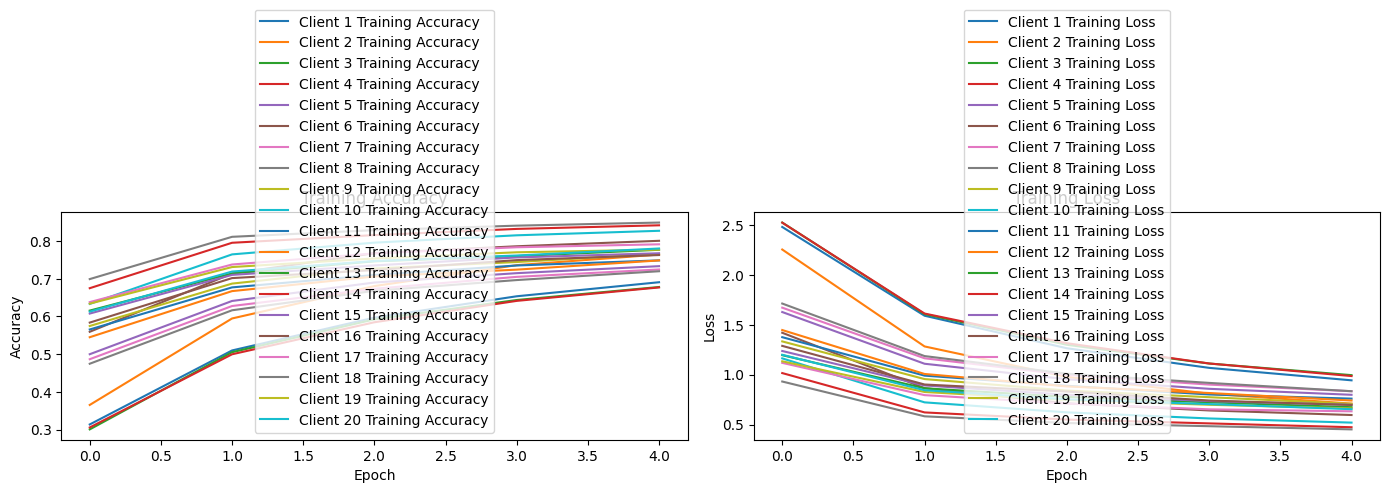

Evaluating Client 1


2024-08-14 00:15:31.586607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8358: Filling up shuffle buffer (this may take a while): 3718 of 4748
2024-08-14 00:15:34.205455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━

/home/rilgpu/anaconda3/envs/shivangFed/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Client 1 - EER: 0.6917, TAR@FAR=0.1: 0.3397, Accuracy: 0.1837
Evaluating Client 2


2024-08-14 00:16:01.627679: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8373: Filling up shuffle buffer (this may take a while): 3626 of 4791


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-08-14 00:16:04.968321: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

/home/rilgpu/anaconda3/envs/shivangFed/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Client 2 - EER: 0.6704, TAR@FAR=0.1: 0.2382, Accuracy: 0.1177
Evaluating Client 3


2024-08-14 00:16:29.682165: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8388: Filling up shuffle buffer (this may take a while): 3679 of 4921


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-08-14 00:16:32.680517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

2024-08-14 00:16:48.440607: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11244446097026228955
2024-08-14 00:16:48.440638: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5588240256128275516
/home/rilgpu/anaconda3/envs/shivangFed/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Client 3 - EER: 0.6901, TAR@FAR=0.1: 0.2942, Accuracy: 0.1420
Evaluating Client 4


2024-08-14 00:16:58.453463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:8403: Filling up shuffle buffer (this may take a while): 3831 of 4878


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


2024-08-14 00:17:01.137561: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━

/home/rilgpu/anaconda3/envs/shivangFed/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


In [ ]:
import os
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.data import Dataset
from sklearn.metrics import roc_curve
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import kerastuner as kt

print("TensorFlow version:", tf.__version__)
print("OpenCV version:", cv2.__version__)

# Set the paths
data_dir = 'Non-iid datasets'
batch_size = 32
img_height = 224
img_width = 224
num_classes = 19  # Number of classes

def load_and_preprocess_image(path, label):
    """Load and preprocess an image."""
    img = cv2.imread(path.decode('utf-8'))  # path needs to be decoded from bytes
    img = cv2.resize(img, (img_width, img_height))
    img = img / 255.0  # Normalize to [0, 1]
    label = tf.one_hot(label, num_classes)  # One-hot encode the label
    return img.astype(np.float32), label.numpy().astype(np.float32)

def augment_image(image):
    """Apply random augmentations to an image."""
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image

def create_dataset(data_dir, batch_size, augment=False):
    """Create a dataset from the given directory."""
    image_paths = []
    labels = []
    class_names = os.listdir(data_dir)

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(label)

    image_paths = np.array(image_paths)
    labels = np.array(labels)

    def generator():
        for img_path, label in zip(image_paths, labels):
            yield img_path, label

    dataset = Dataset.from_generator(generator, output_signature=(
        tf.TensorSpec(shape=(), dtype=tf.string),
        tf.TensorSpec(shape=(), dtype=tf.int32),
    ))

    dataset = dataset.map(lambda x, y: tf.numpy_function(load_and_preprocess_image, [x, y], [tf.float32, tf.float32]))

    # Explicitly set the shapes
    dataset = dataset.map(lambda x, y: (tf.ensure_shape(x, [img_height, img_width, 3]), tf.ensure_shape(y, [num_classes])))

    if augment:
        dataset = dataset.map(lambda x, y: (augment_image(x), y))

    dataset = dataset.shuffle(buffer_size=len(image_paths))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset, len(class_names)

clients_train_data = []
clients_test_data = []

for i in range(1, 5):  # Adjusted to 4 clients
    client_train_path = os.path.join(data_dir, f'client_{i}', 'train')
    client_test_path = os.path.join(data_dir, f'client_{i}', 'test')
    train_data, _ = create_dataset(client_train_path, batch_size, augment=True)
    test_data, _ = create_dataset(client_test_path, batch_size, augment=False)
    clients_train_data.append(train_data)
    clients_test_data.append(test_data)

def create_model(num_classes):
    """Create a MobileNetV2-based model with batch normalization and dropout."""
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

    # Only use the bottom layers of MobileNetV2 to prevent overfitting
    base_model.trainable = False
    x = base_model.layers[-56].output  # Use only the bottom layers

    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = Dropout(0.5)(x)  # Add dropout for regularization
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)  # Add Batch Normalization
    x = Dropout(0.5)(x)  # Add dropout for regularization
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def client_train(model, train_data, client_num, epochs=1):
    """Train the model for a single client."""
    early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
    checkpoint = ModelCheckpoint(f'client_{client_num + 1}_best_model.keras', monitor='loss', save_best_only=True)
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=2, min_lr=0.00001)
    csv_logger = CSVLogger(f'client_{client_num + 1}_training_log.csv')

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    print(f"Compiling model for client {client_num + 1}")
    history = model.fit(train_data, epochs=epochs, verbose=1, callbacks=[early_stopping, checkpoint, reduce_lr, csv_logger])

    return model.get_weights(), history

def fedwpr_aggregation(local_weights, RR):
    """Aggregate local model weights using FedWPR."""
    N = len(local_weights)
    aggregated_weights = []

    for layer_weights in zip(*local_weights):
        rr_component = tf.zeros_like(layer_weights[0])
        one_minus_rr_component = tf.zeros_like(layer_weights[0])

        # Calculate RR component
        for weights in layer_weights:
            rr_component += RR * tf.convert_to_tensor(weights) / N

        # Calculate (1 - RR) component
        for weights in layer_weights:
            one_minus_rr_component += (1 - RR) * tf.convert_to_tensor(weights) / N

        # Combine both components
        new_layer_weights = rr_component + one_minus_rr_component
        aggregated_weights.append(new_layer_weights)

    return aggregated_weights

def plot_training_history(training_histories, num_rounds, num_epochs):
    """Plot training and validation accuracy and loss over rounds and epochs."""
    plt.figure(figsize=(14, 8))

    # Plot training accuracy
    plt.subplot(2, 2, 1)
    for client_num, history in enumerate(training_histories):
        plt.plot(history.history['accuracy'], label=f'Client {client_num + 1} Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training loss
    plt.subplot(2, 2, 2)
    for client_num, history in enumerate(training_histories):
        plt.plot(history.history['loss'], label=f'Client {client_num + 1} Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

def calculate_eer_tarf(predictions, labels):
    """Calculate EER and TAR@FAR=0.1."""
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(labels, predictions)

    # Calculate EER
    eer_threshold = brentq(lambda x: 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    eer = interp1d(fpr, tpr)(eer_threshold)

    # Calculate TAR@FAR=0.1
    far_target = 0.1
    tar = tpr[np.where(fpr <= far_target)[0][-1]]

    return eer, tar

def evaluate_model_with_metrics(model, test_data, client_num):
    """Evaluate the model and calculate EER and TAR@FAR=0.1."""
    predictions = []
    true_labels = []

    for images, labels in test_data:
        preds = model.predict(images)
        predictions.extend(preds)
        true_labels.extend(labels.numpy())

    predictions = np.array(predictions).ravel()
    true_labels = np.array(true_labels).ravel()

    eer, tar = calculate_eer_tarf(predictions, true_labels)
    loss, accuracy = model.evaluate(test_data, verbose=0)

    print(f"Client {client_num + 1} - EER: {eer:.4f}, TAR@FAR=0.1: {tar:.4f}, Accuracy: {accuracy:.4f}")

    return eer, tar, accuracy

def federated_learning_experiment_with_metrics(num_rounds, num_epochs, RR):
    """Run a federated learning experiment with EER and TAR@FAR=0.1 evaluation."""
    global_model = create_model(num_classes=num_classes)
    training_histories = []

    for round_num in range(num_rounds):
        print(f"Federated Round {round_num + 1}/{num_rounds}")
        local_weights = []
        round_history = []
        for client_num, train_data in enumerate(clients_train_data):
            print(f"Training Client {client_num + 1}")
            client_model = create_model(num_classes=num_classes)
            client_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
            client_model.set_weights(global_model.get_weights())
            client_weights, history = client_train(client_model, train_data, client_num, epochs=num_epochs)
            local_weights.append(client_weights)
            round_history.append(history)

        training_histories.extend(round_history)

        # Aggregate with FedWPR
        print("Aggregating local models with FedWPR")
        new_global_weights = fedwpr_aggregation(local_weights, RR)
        global_model.set_weights(new_global_weights)

    plot_training_history(training_histories, num_rounds, num_epochs)

    # Evaluate the final global model on each client's test data with EER and TAR@FAR=0.1
    global_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    accuracies, eers, tars = [], [], []
    for client_num, test_data in enumerate(clients_test_data):
        print(f"Evaluating Client {client_num + 1}")
        eer, tar, accuracy = evaluate_model_with_metrics(global_model, test_data, client_num)
        eers.append(eer)
        tars.append(tar)
        accuracies.append(accuracy)

    mean_accuracy = np.mean(accuracies)
    mean_eer = np.mean(eers)
    mean_tar = np.mean(tars)

    print(f"Mean Accuracy: {mean_accuracy:.4f}, Mean EER: {mean_eer:.4f}, Mean TAR@FAR=0.1: {mean_tar:.4f}")

    # Save the global model
    global_model_path = f'federated_global_model_{mean_accuracy:.4f}.keras'
    global_model.save(global_model_path)
    print(f"Saved global model to {global_model_path}")

    return mean_accuracy, mean_eer, mean_tar, global_model_path

# Define the optimal hyperparameters
best_num_rounds = 5
best_num_epochs = 5
best_RR = 0.6

# Run the experiment with the defined hyperparameters
best_accuracy, best_eer, best_tar, best_model_path = federated_learning_experiment_with_metrics(
    best_num_rounds, best_num_epochs, best_RR
)
print(f"Best model saved at: {best_model_path} with mean accuracy: {best_accuracy:.4f}, EER: {best_eer:.4f}, TAR@FAR=0.1: {best_tar:.4f}")